# Coding Section 2
## Econ 130
GSIs: Richard Calvo and Julia Paris

### Goals for today
* Do some data analysis, building up to a diff-in-diff
* We will start with what we did in the previous section, but we will not assume any knowledge other than what we covered.


Often times, user written open-source packages are needed for specific functionality in R (e.g. nice graphics). However, we need to manually install these packages (once) and load them at the beginning of every script. Packages have been pre-installed in Jupyter notebooks.  

*If you are wondering why a command you've used before is no longer working, it may be because you haven't loaded the package.*

In [90]:
# Clear any existing output and data stored in memory
rm(list = ls())

# Read in the data that we constructed last time
mw_no_shore <- read.csv('minwage_no_shore.csv')
head(mw_no_shore)

,store_id,interview,chain,co_owned,state,southj,centralj,northj,pa1,pa2,...,open_hr,hrs_open,p_soda,p_fry,p_entree,n_regs,n_regs11,bonus,pa,nj
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,1,1,1,0,1,0,1,0,0,0,...,7,16,0.93,0.83,0.85,4,3,0,0,1
2,1,2,1,0,1,0,1,0,0,0,...,7,16,1.05,0.79,0.90,4,3,NA,0,1
3,2,1,1,0,1,0,1,0,0,0,...,7,14,1.06,0.91,0.96,2,2,1,0,1
4,2,2,1,0,1,0,1,0,0,0,...,7,15,1.05,1.01,0.94,2,2,NA,0,1
5,3,1,2,0,1,0,1,0,0,0,...,11,10,1.06,0.95,3.09,5,3,1,0,1
6,3,2,2,0,1,0,1,0,0,0,...,11,11,1.05,0.94,2.75,5,3,NA,0,1


Warning message:
"Removed 50 rows containing missing values or values outside the scale range
(`geom_point()`)."


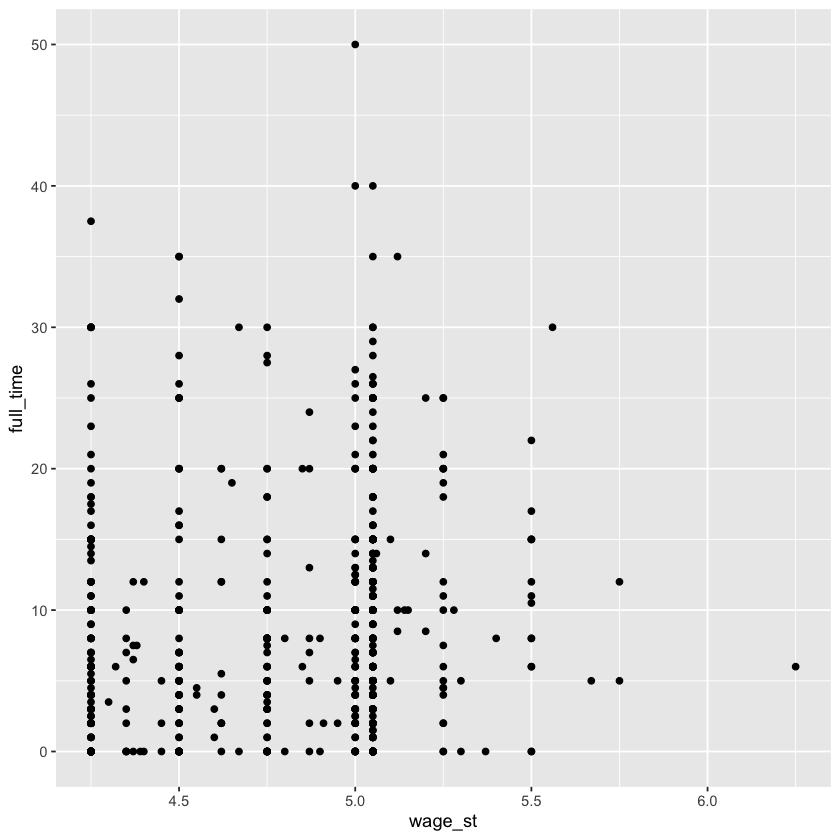

In [91]:
# Let's try to visualize the relationship between employment (full_time)
# and wages (wage_st, the starting wage).

library(ggplot2)

# First, we'll try a scatterplot
basic_plot <- ggplot(data = mw_no_shore, aes(x = wage_st, y = full_time)) +
  geom_point()

basic_plot

Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`)."


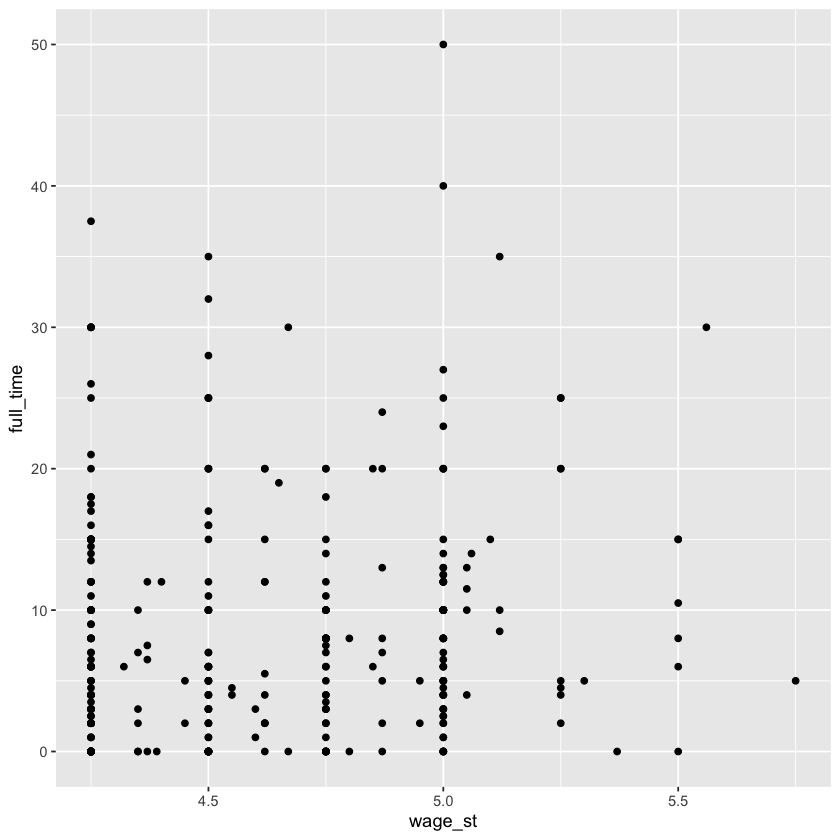

In [92]:
# Now, we want visualize the relationship between employment
# and wages in the pre-period. 

# Create a new dataframe called "pre_data" which contains only data from the pre-period
# (hint: pre data was collected in the first interview (interview==1))

pre_data <- mw_no_shore[mw_no_shore$interview == 1, ]

# Plot a scatterplot of employment against wages using 
# observations from "pre_data"

pre_plot <- ggplot(data = pre_data, aes(x = wage_st, y = full_time)) +
  geom_point()

pre_plot

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 24 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`)."


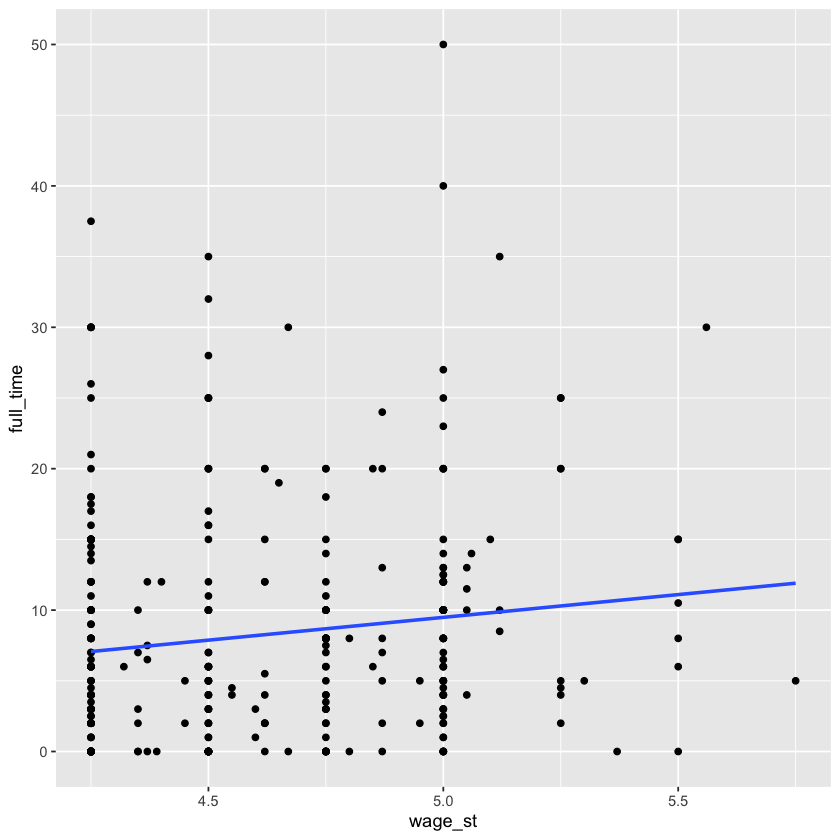

In [93]:
# The scatterplot is hard to interpret! 
# Let's add a line of best fit

pre_plot + geom_smooth(method = "lm", se = FALSE)

## Correlations vs Regressions

In [94]:
# What is the correlation between full-time and part-time employees, and wages? How do we read this table?
# Note: the user = "complete.obs" is necessary in order to tell R to ignore missing data. Otherwise it will
# return a lot of NA's (you can try it if you want!).

cor(mw_no_shore[, c('full_time','part_time','wage_st')], use = "complete.obs")

,full_time,part_time,wage_st
full_time,1.0000000,-0.23052929,0.10826387
part_time,-0.2305293,1.00000000,-0.05993233
wage_st,0.1082639,-0.05993233,1.00000000


In [95]:
# Recall (from lecture) that the correlation coefficient is not the same as the regression 
# coefficient, although they are related. (If you've taken ECON 140/141, you'll know why. 
# If not, don't worry about it!) For example,

model <- lm(full_time~part_time, data = mw_no_shore)

summary(model)


Call:
lm(formula = full_time ~ part_time, data = mw_no_shore)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.435  -5.908  -1.902   3.745  44.462 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.43547    0.61430   18.62  < 2e-16 ***
part_time   -0.16850    0.02837   -5.94 4.41e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.926 on 730 degrees of freedom
  (18 observations deleted due to missingness)
Multiple R-squared:  0.04611,	Adjusted R-squared:  0.0448 
F-statistic: 35.29 on 1 and 730 DF,  p-value: 4.405e-09


In [96]:
# Now try regressing the number of full-time employees on the starting wage 
# (so y=full_time, x=wage_st)

model <- lm(full_time~wage_st, data = mw_no_shore)

# Print the results using summary()
summary(model)


Call:
lm(formula = full_time ~ wage_st, data = mw_no_shore)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.126  -6.021  -2.055   3.945  41.102 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -3.3865     4.0820  -0.830  0.40704   
wage_st       2.4569     0.8481   2.897  0.00389 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.049 on 698 degrees of freedom
  (50 observations deleted due to missingness)
Multiple R-squared:  0.01188,	Adjusted R-squared:  0.01046 
F-statistic: 8.391 on 1 and 698 DF,  p-value: 0.003889


## Diff-in-Diff Table

For a diff-in-diff, we need to calculate four means: two "pre" means (one each for NJ and for PA) and two "post" means for full-time employment.

Let's make things more intuitive by generating some new variables "treated" and "post."

In [97]:
# Create an indicator for "treated" which is equal to one if a store is in NJ,
# and 0 otherwise

mw_no_shore$treated <- ifelse(mw_no_shore$nj == 1, 1, 0)

# Create an indicator for "post" which is equal to one if an observation is
# in the post period, and 0 otherwise
# Post = 1 if interview == 2 and 0 otherwise

mw_no_shore$post <- ifelse(mw_no_shore$interview == 2, 1, 0)

# Generate the four means needed for a difference-in-difference estimator
# Remember the mean for full_time employment for the entire dataset can be written as:
mean(mw_no_shore$full_time, na.rm = TRUE)

# We'll use the print command to help us organize our output
print("Pre; NJ then PA")

mean(mw_no_shore$full_time[mw_no_shore$post == 0 & mw_no_shore$treated == 1], na.rm = TRUE)
mean(mw_no_shore$full_time[mw_no_shore$post == 0 & mw_no_shore$treated == 0], na.rm = TRUE)

print("Post; NJ then PA")

mean(mw_no_shore$full_time[mw_no_shore$post == 1 & mw_no_shore$treated == 1], na.rm = TRUE)
mean(mw_no_shore$full_time[mw_no_shore$post == 1 & mw_no_shore$treated == 0], na.rm = TRUE)


[1] 8.237381

[1] "Pre; NJ then PA"


[1] 7.589347

[1] 10.20513

[1] "Post; NJ then PA"


[1] 8.54007

[1] 7.564935

Now we can complete the table that we started last week:

## Diff-in-Diff Regression

In [98]:
# Now let's see how we can get the differences with regressions

# Here's a naive regression: a single difference (NJ pre vs. NJ post)
nj_single <- lm(full_time ~ post, data = mw_no_shore[mw_no_shore$nj==1,])
summary(nj_single)

# Which difference in means does this correspond to? Is it causal?


Call:
lm(formula = full_time ~ post, data = mw_no_shore[mw_no_shore$nj == 
    1, ])

Residuals:
   Min     1Q Median     3Q    Max 
-8.540 -5.589 -2.315  4.411 31.460 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.5893     0.4452  17.048   <2e-16 ***
post          0.9507     0.6317   1.505    0.133    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.594 on 576 degrees of freedom
  (14 observations deleted due to missingness)
Multiple R-squared:  0.003916,	Adjusted R-squared:  0.002187 
F-statistic: 2.265 on 1 and 576 DF,  p-value: 0.1329


In [99]:
# What about this version?
post_single <- lm(full_time ~ treated, data = mw_no_shore[mw_no_shore$post==1,])
summary(post_single)


Call:
lm(formula = full_time ~ treated, data = mw_no_shore[mw_no_shore$post == 
    1, ])

Residuals:
   Min     1Q Median     3Q    Max 
 -8.54  -6.54  -2.54   3.46  31.46 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.5649     0.9079   8.332 1.66e-15 ***
treated       0.9751     1.0225   0.954    0.341    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.967 on 362 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.002506,	Adjusted R-squared:  -0.0002492 
F-statistic: 0.9095 on 1 and 362 DF,  p-value: 0.3409


In [100]:
# Now let's do the diff-in-diff

mw_no_shore$treatedxpost <- mw_no_shore$treated * mw_no_shore$post

diff_in_diff <- lm(full_time ~ treated + post + treatedxpost, data = mw_no_shore)

summary(diff_in_diff)

# How can we relate this to the table from the Diff-in-Diff slides?

# Coding note: we could have the same result by using:
# summary(lm(full_time ~ treated*post, data = mw_no_shore))


Call:
lm(formula = full_time ~ treated + post + treatedxpost, data = mw_no_shore)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.205  -6.540  -2.540   3.911  39.795 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   10.2051     0.9153  11.149   <2e-16 ***
treated       -2.6158     1.0307  -2.538   0.0114 *  
post          -2.6402     1.2986  -2.033   0.0424 *  
treatedxpost   3.5909     1.4624   2.455   0.0143 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.084 on 729 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.01009,	Adjusted R-squared:  0.006011 
F-statistic: 2.476 on 3 and 729 DF,  p-value: 0.06033


In [101]:
# How do we feel about this specification?
# Is there anything else you want to control for? Do we have these variables?

# I want to control for chain. Here's a nice way to do it without manually generating
# a lot of variables:

w_chain <- lm(full_time ~ treated + post + treatedxpost + factor(chain), data = mw_no_shore)
summary(w_chain)

# This set of indicator variables for chain are often referred to as "factor variables," which is
# where the R command gets it's name. I figured out how to do this by Googling "R ols factor variables"
# and reading what was the first result for me (from the UCLA stats department)


Call:
lm(formula = full_time ~ treated + post + treatedxpost + factor(chain), 
    data = mw_no_shore)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.785  -5.221  -1.624   3.779  38.215 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     11.7845     0.9524  12.373  < 2e-16 ***
treated         -2.3856     1.0056  -2.372  0.01794 *  
post            -2.6602     1.2645  -2.104  0.03574 *  
treatedxpost     3.6080     1.4239   2.534  0.01149 *  
factor(chain)2  -5.2297     0.8026  -6.516 1.35e-10 ***
factor(chain)3  -2.1780     0.7346  -2.965  0.00313 ** 
factor(chain)4  -1.5606     0.9030  -1.728  0.08436 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.87 on 726 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.0656,	Adjusted R-squared:  0.05788 
F-statistic: 8.495 on 6 and 726 DF,  p-value: 6.219e-09


In [102]:
# What other outcome variables are you interested in that might be related
# to economic hypotheses about raising the minimum wage? Do we have data to test this?

names(mw_no_shore)

[1] "store_id"     "interview"    "chain"        "co_owned"     "state"       
 [6] "southj"       "centralj"     "northj"       "pa1"          "pa2"         
[11] "shore"        "pct_aff"      "type"         "status"       "date"        
[16] "ncalls"       "full_time"    "part_time"    "managers"     "wage_st"     
[21] "inc_time"     "first_inc"    "special"      "meals"        "open_hr"     
[26] "hrs_open"     "p_soda"       "p_fry"        "p_entree"     "n_regs"      
[31] "n_regs11"     "bonus"        "pa"           "nj"           "treated"     
[36] "post"         "treatedxpost"

In [103]:
# For example, let's do a diff-in-diff to see the effect of the minimum
# wage on part-time employees

summary(lm(part_time ~ treated*post, data = mw_no_shore))

# For example, let's do a diff-in-diff to see the effect of the minimum
# wage on wages (like we did in Section 4, but this time more formally)
summary(lm(wage_st ~ treated*post, data = mw_no_shore))


Call:
lm(formula = part_time ~ treated * post, data = mw_no_shore)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.955  -7.737  -1.737   6.263  41.263 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   19.4872     1.1703  16.651   <2e-16 ***
treated       -0.4548     1.3169  -0.345    0.730    
post           0.4674     1.6605   0.281    0.778    
treated:post  -0.7628     1.8686  -0.408    0.683    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 10.34 on 733 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.001355,	Adjusted R-squared:  -0.002733 
F-statistic: 0.3314 on 3 and 733 DF,  p-value: 0.8027



Call:
lm(formula = wage_st ~ treated * post, data = mw_no_shore)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38013 -0.11746 -0.03095  0.13975  1.63254 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.63013    0.03178 145.675   <2e-16 ***
treated      -0.01988    0.03584  -0.555    0.579    
post         -0.01267    0.04573  -0.277    0.782    
treated:post  0.48337    0.05134   9.414   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2771 on 707 degrees of freedom
  (39 observations deleted due to missingness)
Multiple R-squared:  0.4057,	Adjusted R-squared:  0.4032 
F-statistic: 160.9 on 3 and 707 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 17 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 17 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`)."


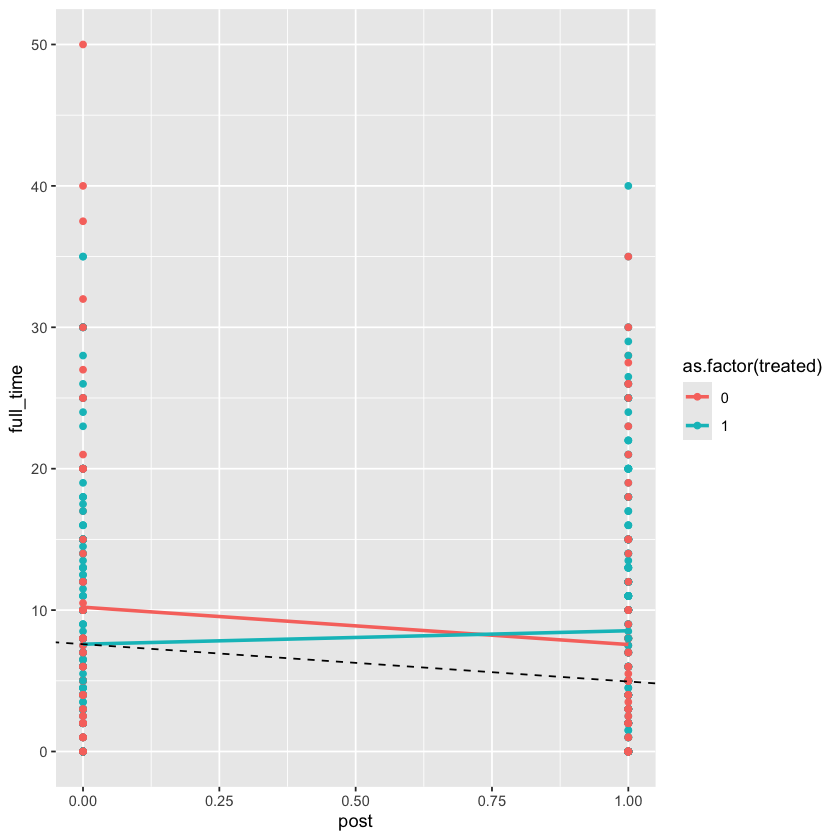

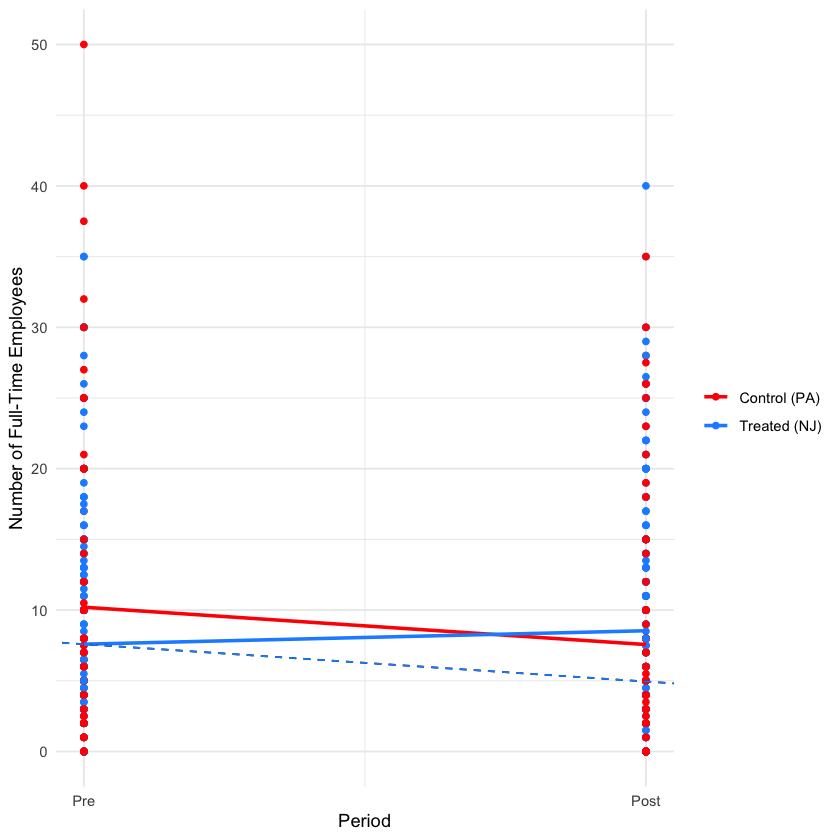

In [104]:
# BONUS: Let's make a plot of the difference-in-difference on full-time employees

diff_in_diff_plot <- ggplot(data = mw_no_shore, aes(x = post, y = full_time, group = treated)) +
  geom_point(aes(color = as.factor(treated))) +
  geom_smooth(aes(color = as.factor(treated)), method = 'lm', se = F) +
  geom_abline(slope = diff_in_diff$coefficients['post'], intercept = 
                diff_in_diff$coefficients['(Intercept)'] + 
                diff_in_diff$coefficients['treated'], linetype = "dashed")

diff_in_diff_plot

diff_in_diff_plot +
  labs(x = "Period",
       y = "Number of Full-Time Employees") +
  scale_color_manual(name = '',
                     labels = c("Control (PA)", "Treated (NJ)"),
                     values = c('0' = "red", '1' = "dodgerblue")) +
  scale_x_continuous(breaks = c(0,1), labels = c('Pre', 'Post')) +
  geom_abline(slope = diff_in_diff$coefficients['post'], intercept = 
                diff_in_diff$coefficients['(Intercept)'] + 
                diff_in_diff$coefficients['treated'], linetype = "dashed", color = "dodgerblue") +
  theme_minimal()
  
  # BONUS: How could we make a similar plot for wages, completing our work from section 4?
